In [1]:
import os 

from AEMG.data_utils import TrajectoryDataset
from AEMG.systems.utils import get_system

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from AEMG.models import *

from tqdm.notebook import tqdm

In [2]:
config_fname = "config/physics_pendulum.txt"
# config_fname = "config/hopper.txt"

with open(config_fname, 'r') as f:
    config = eval(f.read())

traj_dataset = TrajectoryDataset(config)

Getting data for:  physics_pendulum


100%|██████████| 1000/1000 [00:23<00:00, 43.46it/s]


In [3]:
# Get the limits
X_min = np.loadtxt(os.path.join(config['model_dir'], 'X_min.txt'), delimiter=',')
X_max = np.loadtxt(os.path.join(config['model_dir'], 'X_max.txt'), delimiter=',')
print("X_min: ", X_min)
print("X_max: ", X_max)

X_min:  [-1.03603202 -2.84655101 -3.14147697 -9.37398228]
X_max:  [1.03490711 3.10759888 3.14142839 3.5276433 ]


## TODO: Fix this

In [4]:
num_steps = int(len(traj_dataset[0])/config["step"])
max_plotting = len(traj_dataset)*0.05
max_plotting_prob = max_plotting / len(traj_dataset)
print(max_plotting_prob)

0.05


In [5]:
encoder  = Encoder(config['high_dims'], config['low_dims'])
decoder  = Decoder(config['low_dims'], config['high_dims'])
dynamics = LatentDynamics(config['low_dims'])

encoder = torch.load(os.path.join(config['model_dir'], 'encoder.pt'))
decoder = torch.load(os.path.join(config['model_dir'], 'decoder.pt'))
dynamics = torch.load(os.path.join(config['model_dir'], 'dynamics.pt'))

  0%|          | 0/1000 [00:00<?, ?it/s]

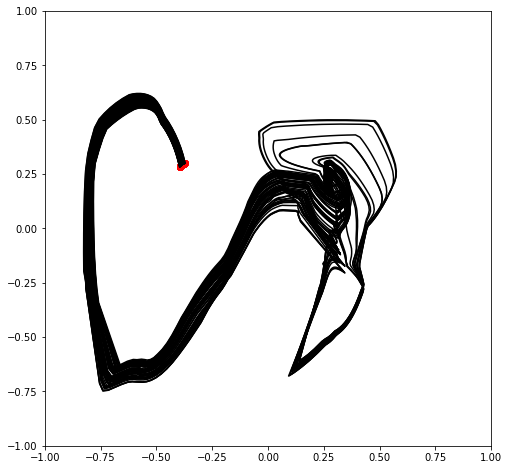

In [6]:
plt.figure(figsize=(8,8))
plt.xlim(-1,1)
plt.ylim(-1,1)

for i in tqdm(range(len(traj_dataset))):
    steps = np.arange(0, len(traj_dataset[i]), config["step"])
    steps = np.hstack([steps, len(traj_dataset[i]) - 1])
    traj = traj_dataset[i]
    traj = torch.from_numpy(traj).float()
    traj = (traj - X_min) / (X_max - X_min)
    traj = traj.unsqueeze(0)
    traj = traj.float()
    z = encoder(traj)
    z = z.squeeze(0)
    z = z.detach().numpy()
    if np.random.rand() < max_plotting_prob:
        plt.plot(z[steps,0], z[steps,1],color='black')
        plt.scatter(z[-1,0], z[-1,1], color='blue')
        plt.scatter(z[0,0], z[0,1], color='red')

  0%|          | 0/1000 [00:00<?, ?it/s]

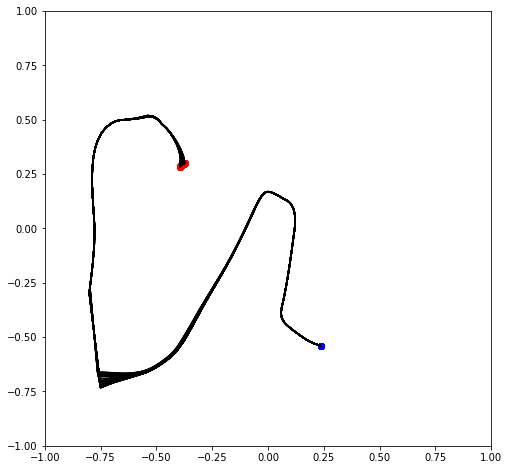

In [7]:
plt.figure(figsize=(8,8))
plt.xlim(-1,1)
plt.ylim(-1,1)
for i in tqdm(range(len(traj_dataset))):
    traj = traj_dataset[i]
    initial_state = (traj[0] - X_min) / (X_max - X_min)
    initial_state = torch.from_numpy(initial_state).float()
    z_traj = []
    z = encoder(initial_state)
    z = z.squeeze(0)
    z = z.detach().numpy()
    z_traj.append(z)
    for j in range(num_steps-1):
        z = torch.from_numpy(z).float()
        z = dynamics(z)
        z = z.squeeze(0)
        z = z.detach().numpy()
        z_traj.append(z)
    z_traj = np.array(z_traj)
    if np.random.rand() < max_plotting_prob:
        plt.plot(z_traj[:,0], z_traj[:,1],color='black')
        plt.scatter(z_traj[0,0], z_traj[0,1], color='red')
        plt.scatter(z_traj[-1,0], z_traj[-1,1], color='blue')

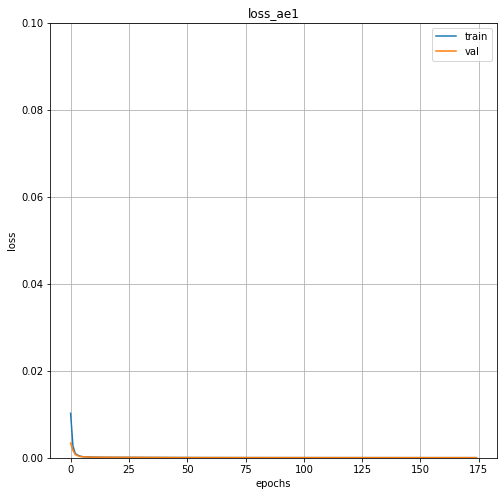

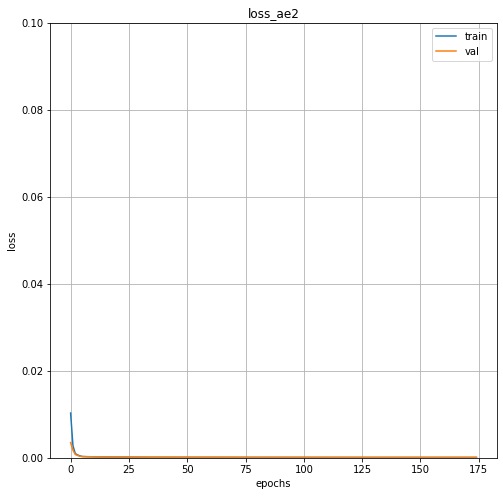

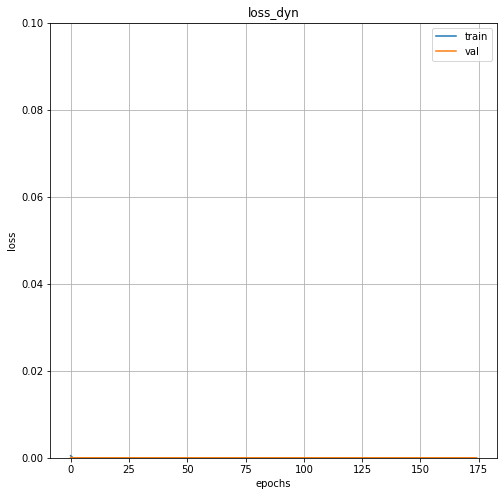

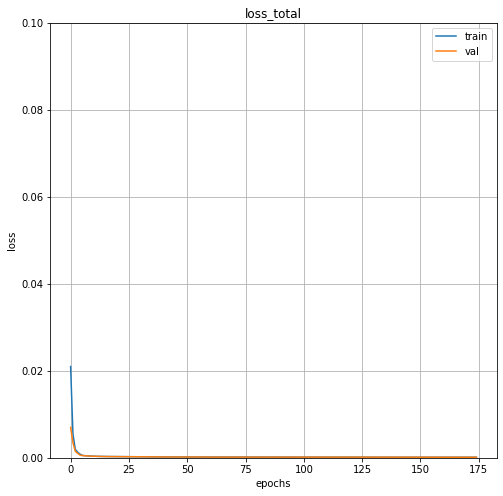

In [8]:
from AEMG.plot_losses import plot_losses

plot_losses(config)